# Tara Saba 9731037

## Importing libraries

In [6]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import math
import time

## 1. Loading the datasets
Loading and feature extraction are done in this section

In [7]:
# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0,0,0,0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4,1)
    train_set.append((train_set_features[i].reshape(102,1), label))
    

for i in range(len(test_set_features)):
    label = np.array([0,0,0,0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4,1)
    test_set.append((test_set_features[i].reshape(102,1), label))

# shuffle

random.shuffle(train_set)
random.shuffle(test_set)
# print size
print(len(train_set)) #1962
print(len(test_set)) #662



1962
662


## 2. Feed forward
### Initializing the weights and biases
Weights are initialized to normal random amounts and all the biases are initialized to zero

In [8]:
def initialize_weights():    
    weights = {}
    biases = {}
    weights[1] = np.random.normal(size=(102,150))
    weights[2] = np.random.normal(size=(150,60))
    weights[3] = np.random.normal(size=(60,4))
    biases[1] = np.zeros(150)
    biases[2] = np.zeros(60)
    biases[3] = np.zeros(4)
    return weights, biases

In [9]:
weights = {}
biases = {}
weights, biases = initialize_weights()

### Sigmoid function

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Sigmoid derivative function

In [11]:
def sigmoid_der(x):
    return (x)*(1-(x))

### Forward propagation for a single layer
Multiple datas could be given to this function

In [12]:
def layer_forward_propagation(a_curr, weights, bias):
    na_curr = np.array(a_curr).reshape(len(a_curr),len(a_curr[0]))
    a_next = np.dot((na_curr), weights) + bias
    return sigmoid(a_next)
    

### Test

In [13]:
print(layer_forward_propagation(np.array([[3,4,5],[3,4,5]]),np.array([[0.5,0.4],[-0.8,0],[0.3,-0.6]]),[0.5,1]))

[[0.57444252 0.31002552]
 [0.57444252 0.31002552]]


### Forward propagation through all layers


In [14]:
def forward_propagation(input_set, weights, biases):
    results = {}
    curr_result = np.array(input_set)
    for layer in weights.keys():
        results[layer]= layer_forward_propagation(curr_result, weights[layer], biases[layer])
        curr_result = results[layer]
    return results
        

### Test

In [15]:
print(forward_propagation(np.array([[3,4,5],[3,4,5]]),{'k':np.array([[0.5,0.4],[-0.8,0],[0.3,-0.6]])},{'k':[0.5,1]}))

{'k': array([[0.57444252, 0.31002552],
       [0.57444252, 0.31002552]])}


### Formatting the input for feed forward

In [16]:
def full_propagation(input_set, weights, biases):
    results = forward_propagation([i[0] for i in input_set], weights, biases)
    return results
    

### Calculating the accuracy of the prediction
The highest activation among the 4 neurons in the last layer is considered to be the predicted fruit.

In [17]:
def calculate_accuracy(predictions, labels):
    counter = 0
    lab = np.zeros(4)
    for i in range(len(predictions)):
        lab = np.array(labels[i][1]).reshape(4)
        if (np.where(predictions[i] == np.amax(predictions[i]))[0]) == (np.where(lab == np.amax(lab))[0]):
            counter +=1
    accuracy = counter/len(predictions)
    return accuracy

### Accuracy testing
Calculating the accuracy of the prediction for 200 datas in the training dataset with random weights

In [18]:
weights, biases = initialize_weights()
print('Accuracy:')
print(calculate_accuracy(full_propagation(train_set[:200],weights, biases)[3],train_set[:200]))

Accuracy:
0.245


## 3 & 4. Non-vectorized and Vectorized Back propagation

### Cost calculation function
Calculating the cost based on sse

In [19]:
def calculate_cost(predictions, labels):
    cost = 0
    labels = np.array(labels).reshape((len(labels),4))
    predictions = np.array(predictions).reshape((len(predictions),4))
    cost_arr = np.zeros((len(labels),4))
    cost_arr = (predictions - labels)**2
#     print(np.array(predictions).shape, np.array(labels).shape, len(predictions))
#     for i in range(4):
#         for j in range(len(predictions)):
#             cost+= cost_arr[j][i]
    cost = np.sum(cost_arr)
    cost = cost/len(predictions)
    return cost

### Non-vectorized partial derivatives calculation for the last layer
Partial derivatives of the cost with respect to the weights, biases and activations results are calculated.

In [20]:
def last_layer_cost_dev(predictions, labels, weights):
    grad_b = np.zeros(4)
    grad_w = np.zeros(shape=(60,4))
    grad_a = np.zeros(60)
    for j in range(4):
        grad_b[j] = (2*predictions[3][0][j]-2*labels[j])*sigmoid_der(predictions[3][0][j])
        for k in range(60):
            grad_w[k][j] = grad_b[j]*predictions[2][0][k]
            grad_a[k] += grad_b[j]*weights[k][j]
    return grad_w, grad_b , grad_a
        

### Non-vectorized partial derivatives calculation for the hidden layers
Partial derivatives of the cost with respect to the weights, biases and activations results are calculated for the hidden layers.

In [21]:
def hidden_layer_cost_dev(predictions, weights, grad_a,i):
    grad_b = np.zeros(len(predictions[i][0]))
    grad_w = np.zeros(shape=(len(predictions[i-1][0]),len(predictions[i][0])))
    grad_aa = np.zeros(len(predictions[i-1][0]))
    for k in range(len(predictions[i][0])):
        grad_b[k] = grad_a[k]*sigmoid_der(predictions[i][0][k])
        for m in range(len(predictions[i-1][0])):
            grad_w[m][k] = grad_b[k]*predictions[i-1][0][m]
            if i!=1:
                grad_aa[m] += grad_b[k]*weights[m][k]
    return grad_w, grad_b , grad_aa

### Vectorized partial derivatives calculation for the last layer
Partial derivatives of the cost with respect to the weights, biases and activations results are calculated.

In [22]:
def vectorized_last_cost_dev(predictions, labels, weights):
    grad_b = np.zeros((4,1))
    grad_w = np.zeros(shape=(60,4))
    grad_a = np.zeros((60,1))
    grad_b = (2* sigmoid_der(predictions[3][0])*(predictions[3][0]-labels)).reshape((4,1))
    grad_w = ((predictions[2][0].reshape((60,1)))) @ np.transpose(grad_b)
    grad_a =  weights @ grad_b 
    return grad_w, grad_b.reshape(4), grad_a.reshape(60)

### Vectorized partial derivatives calculation for the hidden layers
Partial derivatives of the cost with respect to the weights, biases and activations results are calculated for the hidden layers.

In [23]:
def vectorized_hidden_cost_dev(predictions, weights, grad_a,i):
    grad_b = np.zeros((len(predictions[i][0]),1))
    grad_w = np.zeros(shape=(len(predictions[i-1][0]),len(predictions[i][0])))
    grad_aa = np.zeros((len(predictions[i-1][0]),1))
    grad_b = (sigmoid_der(predictions[i][0])*grad_a).reshape((len(predictions[i][0]),1))
    grad_w = ((predictions[i-1][0].reshape((len(predictions[i-1][0]),1)))) @ np.transpose(grad_b)
    if i!= 1:
        grad_aa = weights @ grad_b 
    return grad_w, grad_b.reshape(len(predictions[i][0])), grad_aa.reshape(len(predictions[i-1][0]))

### Plotting cost per epoch

In [24]:
def do_plotting(costs):
    x_ax = [i for i in range(len(costs))]
    y_ax = costs
    plt.plot(x_ax, y_ax,color = 'green')
    plt.show()

### Back propagation function using stochastic gradient descent
The number of epochs,batch size and mode are given as arguments. Mode specifies how the calculations are done (vectorized or non-vectorized)

In [61]:
def back_propagate(input_set, weights, biases, epochs,batch,lrate, mode):
    startTime = time.time()
    BATCH_SIZE = batch
    LEARNING_RATE = lrate
    EPOCHS_NUM = epochs
    num_batches = math.ceil(len(input_set)/BATCH_SIZE)
    cost = np.zeros(EPOCHS_NUM+1)
    cost[0] = calculate_cost(full_propagation(input_set,weights, biases)[3], [i[1] for i in input_set])
    for i in range(EPOCHS_NUM):
        random.shuffle(input_set)
        for j in range(num_batches):
            grad_w = {}
            grad_b = {}
            grad_w[1] = np.zeros(shape=(102,150))
            grad_w[2] = np.zeros(shape=(150,60))
            grad_w[3] = np.zeros(shape=(60,4))
            grad_b[1] = np.zeros(150)
            grad_b[2] = np.zeros(60)
            grad_b[3] = np.zeros(4)
            if j != (num_batches - 1):
                end = (j+1)*BATCH_SIZE
            else:
                end = len(input_set)
            for train in input_set[j*BATCH_SIZE:end]:
                    predictions = full_propagation([train], weights, biases)
                    predictions[0] = [train[0]]
                    lab = np.array(train[1]).reshape(4)
                    grad_a = 0
                    if mode == 'n':
                        x,y,grad_a =last_layer_cost_dev(predictions, lab, weights[3])
                    else:
                        x,y,grad_a =vectorized_last_cost_dev(predictions, lab, weights[3])
                    grad_w[3] += x
                    grad_b[3] += y
                    for h in range(2,0,-1):
                        grad_x = grad_a
                        if mode == 'n':
                            x,y,grad_a = hidden_layer_cost_dev(predictions,weights[h],grad_a,h)
                        else:
                            x,y,grad_a = vectorized_hidden_cost_dev(predictions,weights[h],grad_a,h)
                        grad_w[h]+= x
                        grad_b[h]+=y

            for layer in weights.keys():
                weights[layer] = weights[layer] -(LEARNING_RATE*(grad_w[layer]/BATCH_SIZE))
                biases[layer] = biases[layer] - (LEARNING_RATE*(grad_b[layer]/BATCH_SIZE))
            
            cost[i+1] += calculate_cost(full_propagation(input_set[j*BATCH_SIZE:end],weights, biases)[3], [i[1] for i in input_set[j*BATCH_SIZE:end]])/num_batches
            
    print("Time taken:")
    print(str(round((time.time() - startTime),2)),'s')
#     print(calculate_accuracy(full_propagation(train_set[:200],weights, biases)[3],train_set[:200]))
    return weights, biases,cost

### Testing non-vectorized gradient descent 
Testing non-vectorized calculations with the first 200 datas in the training set with 5 epochs
It can be deducted that the cost of feedforward decreases after each epoch is finished and the weights are updated.

Time taken:
34.05 s
0.6
Cost array:
[0.95748244 0.93480727 0.85245852 0.84555949 0.73500434 0.68592236]


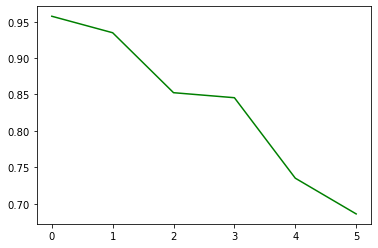

Accuracy:
0.6


In [60]:
weights, biases = initialize_weights()
weights,biases, cost = (back_propagate(train_set[:200],weights, biases,5,10,1 ,'n'))
print('Cost array:')
print(cost)
do_plotting(cost)
print('Accuracy:')
print(calculate_accuracy(full_propagation(train_set[:200],weights, biases)[3],train_set[:200]))

### Testing vectorized gradient descent 
Testing vectorized calculations with the first 200 datas in the training set with 20 epochs.
According to the results of this section and the previous one, the running time of the vectorized algorthim is clearly less than the non-vectorized one since numpy takes control in vectorized calculations and matrix multiplications and calculations can easily be parallelized.
It is also evident that the accuracy increases and the cost decreases when the number of epochs is increased.

Time taken:
0.82 s
[2.4098309  1.47210511 1.56185318 1.08442393 0.45472949 0.2856193
 0.20232999 0.09688639 0.03552883 0.02543697 0.01694908 0.01308315
 0.01112066 0.01092681 0.0121597  0.00603466 0.0072206  0.00600277
 0.00524122 0.00512756 0.00453221]


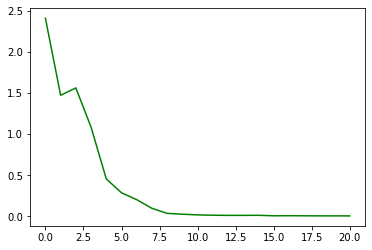

Accuracy:
1.0


In [121]:
weights, biases = initialize_weights()
weights,biases, cost= (back_propagate(train_set[:200],weights, biases, 20, 10, 1 ,'v'))
print(cost)
do_plotting(cost)
print('Accuracy:')
print(calculate_accuracy(full_propagation(train_set[:200],weights, biases)[3],train_set[:200]))

### Running the vectorized algorithm ten times
The average cost diagram is also plotted and the accuracy reported in this section is the mean of accuracies of the ten runs.

In [63]:
def avg_running(input_set, epochs):
    startTime = time.time()
    av_cost = np.zeros(epochs+1)
    av_accuracy = 0
    for i in range(10):
        weights, biases = initialize_weights()
        weights,biases, cost= (back_propagate(input_set,weights, biases, epochs,10,1 ,'v'))
        accuracy = calculate_accuracy(full_propagation(input_set,weights, biases)[3],input_set)
        av_cost = av_cost + cost
        av_accuracy+= accuracy
    print("Total time taken:")
    print(str(round((time.time() - startTime),2)),'s')
    return av_cost/10 , av_accuracy/10, weights ,biases

Time taken:
0.8 s
Time taken:
0.85 s
Time taken:
0.83 s
Time taken:
0.78 s
Time taken:
0.76 s
Time taken:
0.76 s
Time taken:
0.84 s
Time taken:
0.77 s
Time taken:
0.75 s
Time taken:
0.75 s
Total time taken:
7.93 s
Average accuracy:
0.931


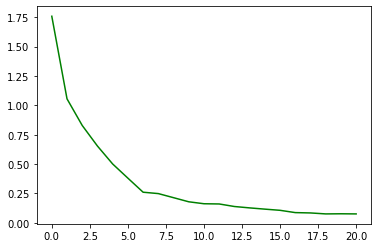

In [65]:
avg_cost, av_accuracy, weights ,biases =  avg_running(train_set[:200], 20)
print('Average accuracy:')
print(av_accuracy)
do_plotting(avg_cost)

## 5. Testing the algorithm

### Trainning the model with the whole sets
Training is done with the train_set and then the cost and accuracy of the model is tested with the whole test_set. These actions are repeated for ten times. Also the mean of costs of train_set in each epoch is plotted.

Time taken:
3.7 s
Time taken:
3.62 s
Time taken:
3.63 s
Time taken:
3.65 s
Time taken:
3.66 s
Time taken:
3.62 s
Time taken:
3.71 s
Time taken:
3.73 s
Time taken:
3.89 s
Time taken:
3.89 s
Total time taken:
37.6 s


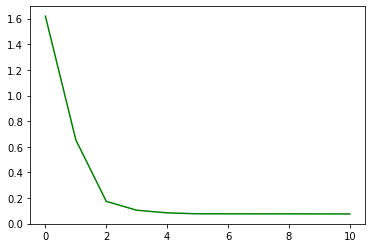

Average accuracy of the training set:
0.9248725790010195
Average accuracy of the test set:
0.9249244712990936
Average cost of the test set:
0.0788348804285476


In [66]:
startTime = time.time()
av_cost = np.zeros(11)
av_tr_ac = 0
av_test_ac = 0
av_cost_test = 0
for i in range(10):
    weights, biases = initialize_weights()
    weights,biases, cost= (back_propagate(train_set,weights, biases, 10,10,1 ,'v'))
    accuracy = calculate_accuracy(full_propagation(train_set,weights, biases)[3],train_set)
    av_tr_ac += accuracy
    av_cost = av_cost + cost
    prediction = full_propagation(test_set,weights, biases)[3]
    accuracy = calculate_accuracy(prediction ,test_set)
    av_test_ac += accuracy
    av_cost_test += calculate_cost(prediction, [i[1] for i in test_set])

print("Total time taken:")
print(str(round((time.time() - startTime),2)),'s')
do_plotting(av_cost/10)
print('Average accuracy of the training set:')
print(av_tr_ac/10)
print('Average accuracy of the test set:')
print(av_test_ac/10)
print('Average cost of the test set:')
print(av_cost_test/10)


## BONUS 1:
The tester function:
Weights are multiplied by 0.1 so that the changes can be more evident.

In [96]:
def tester_function(epoch, batch, learning):
    weights, biases = initialize_weights()
    for l in weights.keys():
        weights[l] = weights[l]* 0.1
    weights,biases, cost= (back_propagate(train_set,weights, biases, epoch, batch, learning ,'v'))
    print(cost)
    do_plotting(cost)
    print('Accuracy:')
    print(calculate_accuracy(full_propagation(train_set,weights, biases)[3],train_set))

### learning_rate = 0.5, epochs_num = 10, batch_size = 10

Time taken:
3.87 s
[1.03693893 0.71066903 0.72402695 0.72487888 0.7029136  0.63002733
 0.45781433 0.29697093 0.18938852 0.1101178  0.0521188 ]


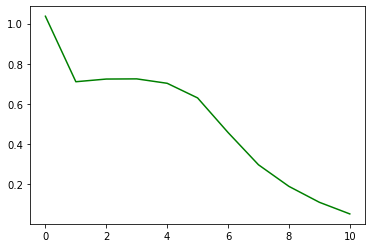

Accuracy:
0.9949031600407747


In [99]:
tester_function(10,10,0.5)

### learning_rate = 0.2, epochs_num = 10, batch_size = 10

Time taken:
3.79 s
[1.07807431 0.72994631 0.72899889 0.72700063 0.72822796 0.72959029
 0.72803649 0.72172411 0.71843407 0.70273832 0.67430026]


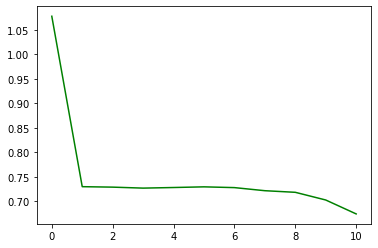

Accuracy:
0.5764525993883792


In [98]:
tester_function(10,10,0.2)

### learning_rate = 0.05, epochs_num = 10, batch_size = 10

Time taken:
4.17 s
[1.00630606 0.76124185 0.7474912  0.74794065 0.74749618 0.74712047
 0.74728629 0.7468985  0.74656261 0.74644701 0.74670059]


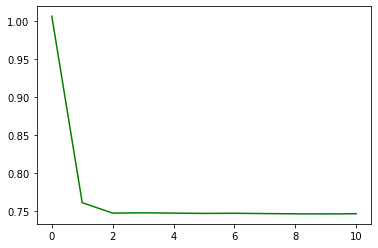

Accuracy:
0.24974515800203873


In [100]:
tester_function(10,10,0.02)

### learning_rate = 2, epochs_num = 10, batch_size = 10

Time taken:
3.83 s
[1.13484908 0.73433564 0.72817423 0.71901777 0.61415551 0.27807924
 0.0508719  0.01669882 0.00646821 0.00296811 0.00162851]


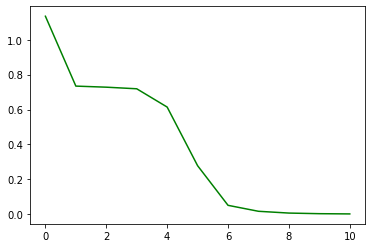

Accuracy:
1.0


In [107]:
tester_function(10,10,2)

### learning_rate = 6, epochs_num = 10, batch_size = 10

Time taken:
3.79 s
[1.1080832  0.78465952 0.67994283 0.54394465 0.33033677 0.32478991
 0.26258903 0.25176282 0.25474921 0.25117226 0.24903271]


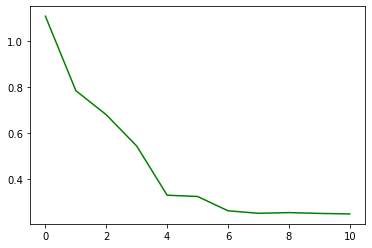

Accuracy:
0.7502548419979612


In [106]:
tester_function(10,10,6)

### learning_rate = 10, epochs_num = 10, batch_size = 10

Time taken:
3.95 s
[1.22579685 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999]


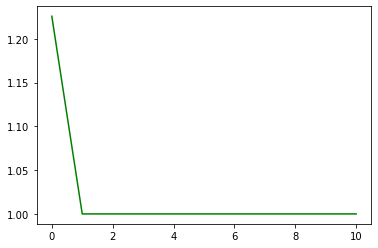

Accuracy:
0.24974515800203873


In [104]:
tester_function(10,10,10)

##### learning_rate = 0.5, epochs_num = 5, batch_size = 10

Time taken:
1.87 s
[1.01961645 0.71586169 0.7265496  0.72665342 0.72286343 0.68814339]


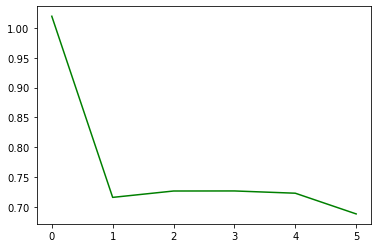

Accuracy:
0.6712538226299695


In [109]:
tester_function(5,10,0.5)

### learning_rate = 0.5, epochs_num = 15, batch_size = 10

Time taken:
5.48 s
[1.10707793 0.71165324 0.7241595  0.72461426 0.71357352 0.6688151
 0.49138287 0.26536372 0.14171244 0.06473511 0.03025248 0.01739549
 0.0124237  0.00946842 0.00677134 0.00553307]


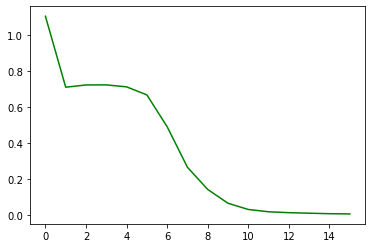

Accuracy:
1.0


In [111]:
tester_function(15,10,0.5)

### learning_rate = 0.5, epochs_num = 5, batch_size = 5

Time taken:
2.08 s
[0.91470966 0.70772912 0.72938676 0.72359834 0.645835   0.30492299]


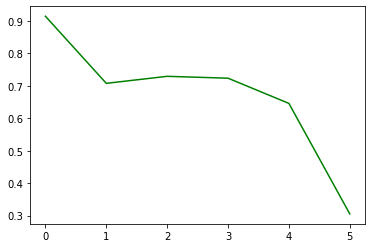

Accuracy:
0.8404689092762487


In [112]:
tester_function(5,5,0.5)

### learning_rate = 0.5, epochs_num = 5, batch_size = 2

Time taken:
2.31 s
[1.09841386 0.7079793  0.72397589 0.65687256 0.29009028 0.09284447]


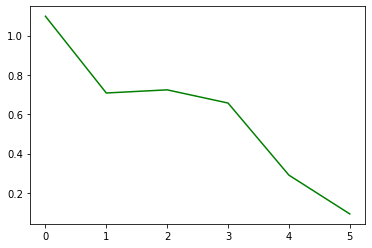

Accuracy:
0.9607543323139653


In [115]:
tester_function(5,2,0.5)

### learning_rate = 0.5, epochs_num = 5, batch_size = 30

Time taken:
1.76 s
[0.99575343 0.73319473 0.73145623 0.73214799 0.73329358 0.72855937]


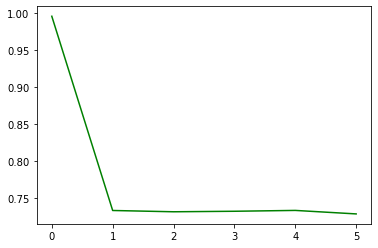

Accuracy:
0.24974515800203873


In [116]:
tester_function(5,30,0.5)

### Analysis

According to the results in each run, it can be deducted that increasing the learning rate to about 2-3 can result in higher accuracy; whereas less amounts can lead to underfitting and higher amount such as 6 or 10 can cause the model to converge too quickly to a suboptimal solution and thus result in less accuracy.
The more epochs there is the more accurate the model gets with the training data, but we need to be cautios with this one since too many epochs can cause overfitting.
The same thing applies to the batch size. The less the batch size is the more accurate the model gets but too little batch size can cause the model to overfit.


Best amounts for hyper parameters:
Learning rate = 2, batch size = 5, Epoch = 15

## Bonus 2

### Gradient Descent optimization with Momentum
Each update in this algorithm would be:<br>
vdw = beta(vdw) + (1-beta)dw <br>
vdb = beta(vdb) + (1-beta)db <br>
Wnew = Wold - (learning_rate)vdw <br>
Bias(new) = Bias(old) - (learning_rate)vdb <br>
The most common value for beta is 0.9 which is a pretty robust value. <br>
SGD with momentum is a method which helps accelerate gradients in the right direction and thus leading to faster and smoother convergence.

In [132]:
def back_propagate_with_momentum(input_set, weights, biases, epochs,batch,lrate, mode):
    startTime = time.time()
    BATCH_SIZE = batch
    LEARNING_RATE = lrate
    EPOCHS_NUM = epochs
    BETA = 0.9
    num_batches = math.ceil(len(input_set)/BATCH_SIZE)
    cost = np.zeros(EPOCHS_NUM+1)
    cost[0] = calculate_cost(full_propagation(input_set,weights, biases)[3], [i[1] for i in input_set])
    vdw = {}
    vdb = {}
    vdw[1] = np.zeros(shape=(102,150))
    vdw[2] = np.zeros(shape=(150,60))
    vdw[3] = np.zeros(shape=(60,4))
    vdb[1] = np.zeros(150)
    vdb[2] = np.zeros(60) 
    vdb[3] = np.zeros(4)
    for i in range(EPOCHS_NUM):
        random.shuffle(input_set)
        for j in range(num_batches):
            grad_w = {}
            grad_b = {}
            grad_w[1] = np.zeros(shape=(102,150))
            grad_w[2] = np.zeros(shape=(150,60))
            grad_w[3] = np.zeros(shape=(60,4))
            grad_b[1] = np.zeros(150)
            grad_b[2] = np.zeros(60)
            grad_b[3] = np.zeros(4)
            if j != (num_batches - 1):
                end = (j+1)*BATCH_SIZE
            else:
                end = len(input_set)
            for train in input_set[j*BATCH_SIZE:end]:
                    predictions = full_propagation([train], weights, biases)
                    predictions[0] = [train[0]]
                    lab = np.array(train[1]).reshape(4)
                    grad_a = 0
                    if mode == 'n':
                        x,y,grad_a =last_layer_cost_dev(predictions, lab, weights[3])
                    else:
                        x,y,grad_a =vectorized_last_cost_dev(predictions, lab, weights[3])
                    grad_w[3] += x
                    grad_b[3] += y
                    for h in range(2,0,-1):
                        grad_x = grad_a
                        if mode == 'n':
                            x,y,grad_a = hidden_layer_cost_dev(predictions,weights[h],grad_a,h)
                        else:
                            x,y,grad_a = vectorized_hidden_cost_dev(predictions,weights[h],grad_a,h)
                        grad_w[h]+= x
                        grad_b[h]+=y
            for layer in weights.keys():
                grad_w[layer] = grad_w[layer]/BATCH_SIZE
                grad_b[layer] = grad_b[layer]/BATCH_SIZE
                vdw[layer] = (BETA)*vdw[layer] + (1-BETA)*grad_w[layer]
                vdb[layer] = (BETA)*vdb[layer] + (1-BETA)*grad_b[layer]
            for layer in weights.keys():
                weights[layer] = weights[layer] -(LEARNING_RATE*(vdw[layer]))
                biases[layer] = biases[layer] - (LEARNING_RATE*(vdb[layer]))
            
            cost[i+1] += calculate_cost(full_propagation(input_set[j*BATCH_SIZE:end],weights, biases)[3], [i[1] for i in input_set[j*BATCH_SIZE:end]])/num_batches
            
    print("Time taken:")
    print(str(round((time.time() - startTime),2)),'s')
#     print(calculate_accuracy(full_propagation(train_set[:200],weights, biases)[3],train_set[:200]))
    return weights, biases,cost

### Testing the SGD algorithm with momentum vs without momentum
For the sake of the argument let's multiply the weights in 0.1 so that the difference could be evident:


In [135]:
def tester_function2(momentum,epoch, batch, learning):
    weights, biases = initialize_weights()
    for l in weights.keys():
        weights[l] = weights[l]* 0.1
    if not momentum:
        weights,biases, cost= (back_propagate(train_set,weights, biases, epoch, batch, learning ,'v'))
    else:
        weights,biases, cost= (back_propagate_with_momentum(train_set,weights, biases, epoch, batch, learning ,'v'))
    print(cost)
    do_plotting(cost)
    print('Accuracy:')
    print(calculate_accuracy(full_propagation(train_set,weights, biases)[3],train_set))

As it can be seen if learning rate is set to 10 which is too high and leads to low accuracy (0.24 in this particular example) in normal SGD, SGD with momentum smooths the convergence and leads to greater accuracy (1 in this particular example).


>> SGD without momentum
Time taken:
3.57 s
[1.08152688 0.99999997 0.99999997 0.99999997 0.99999997 0.99999997
 0.99999997 0.99999997 0.99999997 0.99999997 0.99999997]


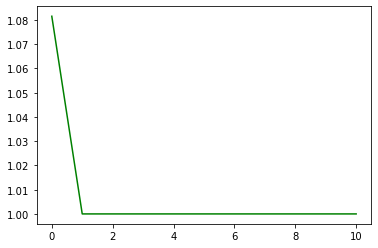

Accuracy:
0.24974515800203873
>> SGD with momentum
Time taken:
3.68 s
[1.30040388e+00 8.50571969e-01 7.58584303e-01 7.58748994e-01
 6.46098879e-01 2.27757946e-01 2.75468632e-03 1.07045268e-03
 7.33606069e-04 5.49641299e-04 4.36941227e-04]


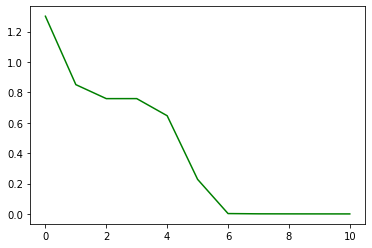

Accuracy:
1.0


In [140]:
print('>> SGD without momentum')
tester_function2(False, 10, 15, 10)
print('>> SGD with momentum')
tester_function2(True, 10, 15, 10)

SGD with momentum also converges faster and leads to lower costs.

>> SGD without momentum
Time taken:
3.61 s
[0.87196542 0.72696694 0.72917044 0.73233494 0.73263214 0.72374738
 0.69223666 0.62712046 0.49503542 0.33475332 0.24112989]


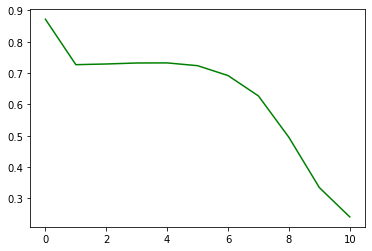

Accuracy:
0.8899082568807339
>> SGD with momentum
Time taken:
3.71 s
[0.89419052 0.76455734 0.75216078 0.74737161 0.73953965 0.7006297
 0.54143886 0.38347589 0.25556007 0.15303721 0.07041881]


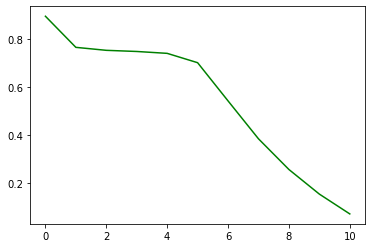

Accuracy:
0.9964322120285423


In [144]:
print('>> SGD without momentum')
tester_function2(False, 10 , 20, 1)
print('>> SGD with momentum')
tester_function2(True, 10, 20, 1)